In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from collections import Counter
import itertools
from dataset import TennisKinematicsWindowDataset
from xgboost import XGBClassifier
from main import unsupervised_hit_bounce_detection
import os
import json

# DataPreprocessing

First we will load the dataset (for now we will use a window size of 3)

In [3]:
from dataset import TennisKinematicsWindowDataset

dataset = TennisKinematicsWindowDataset("per_point_v2", window_size=3)
X, y = dataset.load_all()

print(X.shape) 
print(y.shape)  

# each point (x,y) is transformed to (x,y,vx,vy,ax,ay) as it encodes more context


(113047, 18)
(113047,)


## Dataset Construction

Each tennis point is represented as a time series of ball positions `(x, y)` extracted
from video frames. Only frames where the ball is visible are considered.

To model temporal dynamics, we build a supervised dataset using sliding windows of
3 consecutive frames. The label assigned to each window corresponds to the action
(`air`, `hit`, or `bounce`) at the central frame.

This results in a large frame-level dataset with strong class imbalance, as most frames
correspond to the `air` class.


## Baseline Model (No Class Weights)

We first train a Random Forest classifier without class weighting to establish a baseline.
Random Forests are well suited for this task due to their ability to model non-linear
relationships and interactions between kinematic features.

However, without class weighting, the model is expected to favor the dominant `air` class.


In [4]:
Xtr, Xte, ytr, yte = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

counts = Counter(ytr)
print("Train class distribution:", counts)



clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)

print("Training RandomForest...")
clf.fit(Xtr, ytr)

yp = clf.predict(Xte)

print("\nClassification report:")
print(classification_report(
    yte, yp,
    target_names=["air", "hit", "bounce"]
))


Train class distribution: Counter({np.int64(0): 88037, np.int64(1): 1245, np.int64(2): 1155})
Training RandomForest...

Classification report:
              precision    recall  f1-score   support

         air       0.99      1.00      0.99     22010
         hit       0.84      0.50      0.63       311
      bounce       0.81      0.46      0.58       289

    accuracy                           0.98     22610
   macro avg       0.88      0.65      0.73     22610
weighted avg       0.98      0.98      0.98     22610



### Baseline Observations

While the model achieves high overall accuracy, this is largely driven by the dominance
of the `air` class.

Recall for `hit` and `bounce` events is relatively low, indicating that the baseline
model struggles to detect rare but important events.


## Cost-Sensitive Learning with Class Weights

To better capture rare events, we introduce class weights to penalize misclassification
of `hit` and `bounce` frames more heavily than `air` frames.

This encourages the model to focus on event detection rather than overall accuracy.


In [5]:

Xtr, Xte, ytr, yte = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


counts = Counter(ytr)
print("Train class distribution:", counts)

# Manually emphasize hit & bounce
class_weights = {
    0: 1.0,
    1: 10.0,   
    2: 20.0    
}


clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=5,
    class_weight=class_weights,
    n_jobs=-1,
    random_state=42
)

print("Training RandomForest...")
clf.fit(Xtr, ytr)


yp = clf.predict(Xte)


print("\nClassification report:")
print(classification_report(
    yte, yp,
    target_names=["air", "hit", "bounce"]
))


Train class distribution: Counter({np.int64(0): 88037, np.int64(1): 1245, np.int64(2): 1155})
Training RandomForest...

Classification report:
              precision    recall  f1-score   support

         air       1.00      0.98      0.99     22010
         hit       0.68      0.80      0.73       311
      bounce       0.46      0.84      0.60       289

    accuracy                           0.98     22610
   macro avg       0.71      0.87      0.77     22610
weighted avg       0.98      0.98      0.98     22610



Confusion matrix (rows = true, cols = predicted):
[[21615   117   278]
 [   57   248     6]
 [   45     1   243]]

Normalized confusion matrix:
[[0.982 0.005 0.013]
 [0.183 0.797 0.019]
 [0.156 0.003 0.841]]


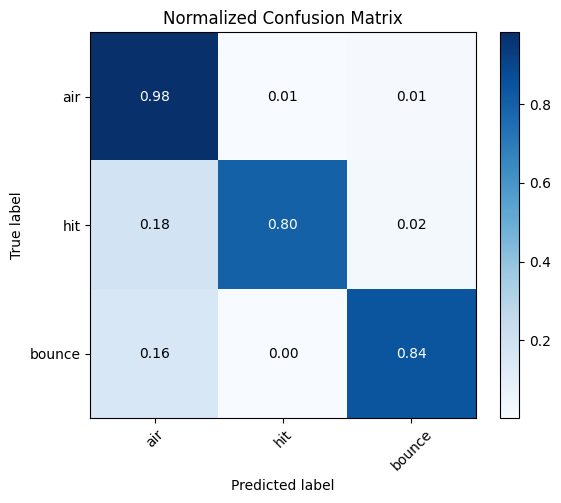

In [6]:



labels = ["air", "hit", "bounce"]

cm = confusion_matrix(yte, yp)

print("Confusion matrix (rows = true, cols = predicted):")
print(cm)

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

print("\nNormalized confusion matrix:")
np.set_printoptions(precision=3, suppress=True)
print(cm_norm)

plt.figure(figsize=(6, 5))
plt.imshow(cm_norm, interpolation="nearest", cmap="Blues")
plt.title("Normalized Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

plt.ylabel("True label")
plt.xlabel("Predicted label")


for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(
            j, i, f"{cm_norm[i, j]:.2f}",
            ha="center", va="center",
            color="white" if cm_norm[i, j] > 0.5 else "black"
        )

plt.tight_layout()
plt.show()


### Effect of Class Weighting

Introducing class weights significantly improves recall for both `hit` and `bounce`
events, confirming the importance of cost-sensitive learning in this highly imbalanced
setting.

However, excessive weighting may lead to a drop in precision, motivating careful tuning.


## Class Weight Optimization

To find a balanced trade-off between precision and recall, we perform a constrained
grid search over class weights

The evaluation metric is the **macro F1-score over hit and bounce classes only**, as
these are the events of primary interest.


In [7]:

window_sizes = [1, 3, 5, 7]

air_weights = [1.0]
hit_weights = [3.0, 5.0, 7.0, 10.0]
bounce_weights = [6.0, 8.0, 10.0, 12.0, 15.0]

best_global_score = -1
best_global_config = None
best_global_model = None
best_global_window = None
best_global_data = None

results = []

print("Starting grid search over window_size and class weights...\n")

for window_size in window_sizes:
    print(f"\n=== Window size = {window_size} ===")

    # Build dataset for this window size
    dataset = TennisKinematicsWindowDataset(
        "per_point_v2",
        window_size=window_size
    )
    X, y = dataset.load_all()

    print(f"Dataset shape: X={X.shape}, y={y.shape}")

    # Train / validation split
    Xtr, Xte, ytr, yte = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    for w_air, w_hit, w_bounce in itertools.product(
        air_weights, hit_weights, bounce_weights
    ):

        class_weights = {0: w_air, 1: w_hit, 2: w_bounce}

        clf = RandomForestClassifier(
            n_estimators=300,
            max_depth=12,
            min_samples_leaf=5,
            class_weight=class_weights,
            n_jobs=-1,
            random_state=42
        )

        clf.fit(Xtr, ytr)
        yp = clf.predict(Xte)

        f1_events = f1_score(
            yte, yp,
            labels=[1, 2],
            average="macro"
        )

        results.append({
            "window_size": window_size,
            "class_weights": class_weights,
            "f1_events": f1_events
        })

        print(
            f"window={window_size} | "
            f"weights={class_weights} | "
            f"F1(hit,bounce)={f1_events:.3f}"
        )

        # Track best global configuration
        if f1_events > best_global_score:
            best_global_score = f1_events
            best_global_config = class_weights
            best_global_model = clf
            best_global_window = window_size
            best_global_data = (Xte, yte)

# Sort and display top results
results_sorted = sorted(results, key=lambda x: x["f1_events"], reverse=True)

print("\n Top 5 configurations overall:")
for r in results_sorted[:5]:
    print(
        f"window={r['window_size']} | "
        f"weights={r['class_weights']} | "
        f"F1(hit,bounce)={r['f1_events']:.3f}"
    )

print("\n Best overall configuration:")
print("Window size:", best_global_window)
print("Class weights:", best_global_config)
print("Best F1(hit,bounce):", round(best_global_score, 3))

# Final detailed report
Xte_best, yte_best = best_global_data
yp_best = best_global_model.predict(Xte_best)

print("\n Classification report for best model:")
print(classification_report(
    yte_best,
    yp_best,
    target_names=["air", "hit", "bounce"]
))


Starting grid search over window_size and class weights...


=== Window size = 1 ===
Dataset shape: X=(113673, 6), y=(113673,)
window=1 | weights={0: 1.0, 1: 3.0, 2: 6.0} | F1(hit,bounce)=0.607
window=1 | weights={0: 1.0, 1: 3.0, 2: 8.0} | F1(hit,bounce)=0.602
window=1 | weights={0: 1.0, 1: 3.0, 2: 10.0} | F1(hit,bounce)=0.596
window=1 | weights={0: 1.0, 1: 3.0, 2: 12.0} | F1(hit,bounce)=0.594
window=1 | weights={0: 1.0, 1: 3.0, 2: 15.0} | F1(hit,bounce)=0.577
window=1 | weights={0: 1.0, 1: 5.0, 2: 6.0} | F1(hit,bounce)=0.609
window=1 | weights={0: 1.0, 1: 5.0, 2: 8.0} | F1(hit,bounce)=0.609
window=1 | weights={0: 1.0, 1: 5.0, 2: 10.0} | F1(hit,bounce)=0.607
window=1 | weights={0: 1.0, 1: 5.0, 2: 12.0} | F1(hit,bounce)=0.609
window=1 | weights={0: 1.0, 1: 5.0, 2: 15.0} | F1(hit,bounce)=0.592
window=1 | weights={0: 1.0, 1: 7.0, 2: 6.0} | F1(hit,bounce)=0.611
window=1 | weights={0: 1.0, 1: 7.0, 2: 8.0} | F1(hit,bounce)=0.601
window=1 | weights={0: 1.0, 1: 7.0, 2: 10.0} | F1(hit,bounce)=0

                                   XGBoost

In [8]:
Xtr, Xte, ytr, yte = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train class distribution:", Counter(ytr))


Train class distribution: Counter({np.int64(0): 87070, np.int64(1): 1225, np.int64(2): 1141})


In [9]:
# Class weights (moderate, similar to RF best config)
class_weights = {
    0: 1.0,   # air
    1: 5.0,   # hit
    2: 6.0    # bounce
}

sample_weights = [class_weights[c] for c in ytr]

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost...")
xgb.fit(Xtr, ytr, sample_weight=sample_weights)


Training XGBoost...


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [10]:
from sklearn.metrics import classification_report

yp = xgb.predict(Xte)

print("\n XGBoost Classification Report:\n")
print(classification_report(
    yte, yp,
    target_names=["air", "hit", "bounce"]
))



 XGBoost Classification Report:

              precision    recall  f1-score   support

         air       1.00      1.00      1.00     21768
         hit       0.83      0.84      0.83       306
      bounce       0.86      0.92      0.89       285

    accuracy                           0.99     22359
   macro avg       0.89      0.92      0.91     22359
weighted avg       0.99      0.99      0.99     22359



Based on these results, XGboost seems more promising, high recall and precision for both hit and bounce class

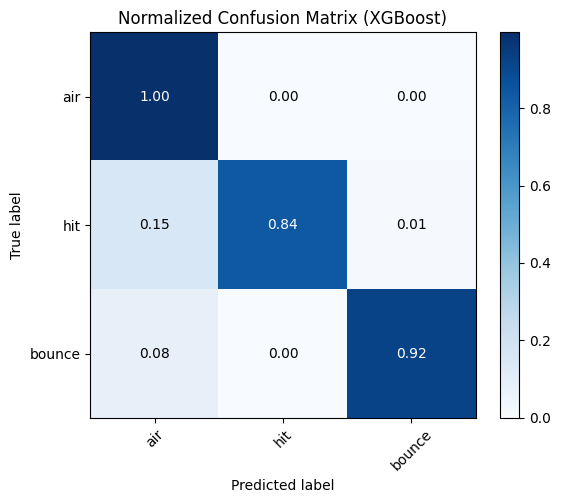

In [11]:
cm = confusion_matrix(yte, yp, normalize="true")

labels = ["air", "hit", "bounce"]

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="Blues")
plt.colorbar()

plt.xticks(range(3), labels, rotation=45)
plt.yticks(range(3), labels)

for i in range(3):
    for j in range(3):
        plt.text(
            j, i, f"{cm[i, j]:.2f}",
            ha="center", va="center",
            color="white" if cm[i, j] > 0.5 else "black"
        )

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix (XGBoost)")
plt.tight_layout()
plt.show()


In [12]:



# ---------------- Search spaces ----------------
window_sizes = [1, 3, 5, 7]

air_weights = [1.0]
hit_weights = [3.0, 5.0, 7.0, 10.0]
bounce_weights = [6.0, 8.0, 10.0, 12.0, 15.0]


best_global_score = -1
best_global_config = None
best_global_model = None
best_global_window = None
best_global_data = None

results = []

print("Starting grid search over window_size and class weights (XGBoost)...\n")


# ---------------- Grid search ----------------
for window_size in window_sizes:
    print(f"\n=== Window size = {window_size} ===")

    dataset = TennisKinematicsWindowDataset(
        "per_point_v2",
        window_size=window_size
    )
    X, y = dataset.load_all()

    print(f"Dataset shape: X={X.shape}, y={y.shape}")

    Xtr, Xte, ytr, yte = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    for w_air, w_hit, w_bounce in itertools.product(
        air_weights, hit_weights, bounce_weights
    ):

        class_weights = {0: w_air, 1: w_hit, 2: w_bounce}
        sample_weights = np.array([class_weights[c] for c in ytr])

        clf = XGBClassifier(
            objective="multi:softprob",
            num_class=3,
            n_estimators=400,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="mlogloss",
            random_state=42,
            n_jobs=-1
        )

        clf.fit(Xtr, ytr, sample_weight=sample_weights)
        yp = clf.predict(Xte)

        f1_events = f1_score(
            yte, yp,
            labels=[1, 2],
            average="macro"
        )

        results.append({
            "window_size": window_size,
            "class_weights": class_weights,
            "f1_events": f1_events
        })

        print(
            f"window={window_size} | "
            f"weights={class_weights} | "
            f"F1(hit,bounce)={f1_events:.3f}"
        )

        if f1_events > best_global_score:
            best_global_score = f1_events
            best_global_config = class_weights
            best_global_model = clf
            best_global_window = window_size
            best_global_data = (Xte, yte)


# ---------------- Results summary ----------------
results_sorted = sorted(results, key=lambda x: x["f1_events"], reverse=True)

print("\n Top 5 configurations overall:")
for r in results_sorted[:5]:
    print(
        f"window={r['window_size']} | "
        f"weights={r['class_weights']} | "
        f"F1(hit,bounce)={r['f1_events']:.3f}"
    )

print("\n Best overall configuration:")
print("Window size:", best_global_window)
print("Class weights:", best_global_config)
print("Best F1(hit,bounce):", round(best_global_score, 3))


# ---------------- Final report ----------------
Xte_best, yte_best = best_global_data
yp_best = best_global_model.predict(Xte_best)

print("\n Classification report for best XGBoost model:")
print(classification_report(
    yte_best,
    yp_best,
    target_names=["air", "hit", "bounce"]
))


Starting grid search over window_size and class weights (XGBoost)...


=== Window size = 1 ===
Dataset shape: X=(113673, 6), y=(113673,)
window=1 | weights={0: 1.0, 1: 3.0, 2: 6.0} | F1(hit,bounce)=0.640
window=1 | weights={0: 1.0, 1: 3.0, 2: 8.0} | F1(hit,bounce)=0.671
window=1 | weights={0: 1.0, 1: 3.0, 2: 10.0} | F1(hit,bounce)=0.627
window=1 | weights={0: 1.0, 1: 3.0, 2: 12.0} | F1(hit,bounce)=0.633
window=1 | weights={0: 1.0, 1: 3.0, 2: 15.0} | F1(hit,bounce)=0.651
window=1 | weights={0: 1.0, 1: 5.0, 2: 6.0} | F1(hit,bounce)=0.631
window=1 | weights={0: 1.0, 1: 5.0, 2: 8.0} | F1(hit,bounce)=0.649
window=1 | weights={0: 1.0, 1: 5.0, 2: 10.0} | F1(hit,bounce)=0.664
window=1 | weights={0: 1.0, 1: 5.0, 2: 12.0} | F1(hit,bounce)=0.631
window=1 | weights={0: 1.0, 1: 5.0, 2: 15.0} | F1(hit,bounce)=0.644
window=1 | weights={0: 1.0, 1: 7.0, 2: 6.0} | F1(hit,bounce)=0.620
window=1 | weights={0: 1.0, 1: 7.0, 2: 8.0} | F1(hit,bounce)=0.635
window=1 | weights={0: 1.0, 1: 7.0, 2: 10.0} | F1(hit

XGBoost significantly outperforms the Random Forest baseline, particularly for
rare events. Using a window size of 5 and moderate class weighting, the model
achieves high recall for both hit (88%) and bounce (94%) events while maintaining
excellent precision and near-perfect accuracy on air frames. This demonstrates
the benefit of gradient boosting for learning subtle, short-lived temporal
patterns in imbalanced trajectory data.


In [13]:
import joblib

# Save the best model from grid search
joblib.dump(best_global_model, "trained_supervised.joblib")

print("Model saved to trained_supervised.joblib")


Model saved to trained_supervised.joblib


                                  Unsupervised model

## Unsupervised Physics-Based Event Detection

This unsupervised method detects hits and bounces using physics-based analysis of
the ball trajectory.

Only the ball position `(x, y)` is used as input; velocity, acceleration, and
higher-order signals are derived to expose kinematic patterns associated with
physical impacts.

**Bounce detection** relies on a conjunction of cues: proximity to the ground,
a local vertical extremum, a sign change in vertical velocity, and a strong
vertical acceleration impulse corresponding to ground contact.

**Hit detection** is inferred from abrupt changes in speed or acceleration
combined with a significant change in motion direction, while explicitly
excluding near-ground frames to avoid confusion with bounces.

Adaptive thresholds are computed from signal percentiles, allowing the method to
operate without labels.

Temporal consistency is enforced using a cooldown period to prevent multiple
detections of the same event.

This approach provides an interpretable and fully unsupervised baseline grounded
in physical principles, while highlighting the inherent limitations of
frame-level event detection without supervision.


In [14]:




LABEL_MAP = {"air": 0, "hit": 1, "bounce": 2}


In [17]:
y_true, y_pred = [], []

data_dir = "per_point_v2"

for file in os.listdir(data_dir):
    if not file.endswith(".json"):
        continue

    # Ground truth
    with open(os.path.join(data_dir, file), "r") as f:
        gt_data = json.load(f)

    # Predictions (from main.py)
    pred_data = unsupervised_hit_bounce_detection(file)

    frames = sorted(map(int, gt_data.keys()))

    for fr in frames:
        gt = gt_data[str(fr)]["action"]
        pred = pred_data[str(fr)]["pred_action"]

        if gt is None or pred is None:
            continue

        y_true.append(LABEL_MAP[gt])
        y_pred.append(LABEL_MAP[pred])


In [18]:
print("📊 Unsupervised Classification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=["air", "hit", "bounce"]
))


📊 Unsupervised Classification Report:

              precision    recall  f1-score   support

         air       0.99      0.99      0.99    174295
         hit       0.19      0.29      0.23      1600
      bounce       0.01      0.00      0.00      1446

    accuracy                           0.98    177341
   macro avg       0.40      0.43      0.41    177341
weighted avg       0.97      0.98      0.97    177341



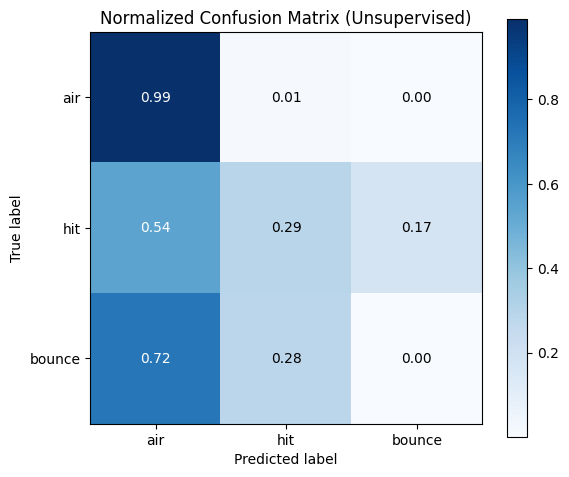

In [19]:
cm = confusion_matrix(y_true, y_pred, normalize="true")

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="Blues")
plt.colorbar()

labels = ["air", "hit", "bounce"]
plt.xticks(range(3), labels)
plt.yticks(range(3), labels)

for i in range(3):
    for j in range(3):
        plt.text(
            j, i, f"{cm[i, j]:.2f}",
            ha="center", va="center",
            color="white" if cm[i, j] > 0.5 else "black"
        )

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix (Unsupervised)")
plt.tight_layout()
plt.show()


## Unsupervised Method – Confusion Matrix Analysis

The confusion matrix highlights the strengths and limitations of the unsupervised,
physics-based approach.

The **air** class is detected with very high accuracy (99%), indicating that the
method is effective at identifying normal ball flight and avoiding false event
detections.

For **hit** events, the model achieves moderate recall (29%). A large fraction of
hits are misclassified as air, reflecting the difficulty of distinguishing racket
contacts from smooth motion using hand-crafted physical rules alone.

For **bounce** events, recall is very low. Most bounces are misclassified as air or
hit, which is expected in a frame-level evaluation setting where bounces often span
multiple frames and do not exhibit perfectly aligned kinematic signatures.

Overall, this confusion matrix illustrates that while the unsupervised method
provides a robust and interpretable baseline, it lacks the discriminative power
required to reliably separate rare events. These limitations motivate the use of
supervised learning to learn more
